In [18]:
# coding: utf-8
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from scipy import linalg
from tqdm import tqdm
import random
from sklearn import svm

path=r'D:\课件\大三暑期\投资学\1论文\data'    # 目录
code = os.listdir(path)    # 目录下的文件名
for c in code:
    index=pd.read_csv(path+'\\'+c,parse_dates=['Date'])
    # print(index)

In [19]:
def getStockData(stock,bar_num,start_date,end_date):
        #1.读取数据
        data_raw = pd.read_csv(path+'\\'+stock)
        index_data =  pd.read_csv(path+'\\'+stock,parse_dates=['Date'])   #parse_dates
        #选取字段
        index_data = index_data[['Date','price']]
        date = index_data.loc[:, 'Date']
        index_data['Date'] = date.astype(int)
        #按日期排序
        index_data.sort_values(by='Date', inplace=True)
        #设置日期索引
        index_data.set_index('Date', inplace=True)
            
        #2.特征处理
        #这里以当日收盘价和之前n天的收盘价作为特征
        for i in range(1,bar_num+1):
            index_data['price_'+str(i)] = index_data['price'].shift(i)            
        #去掉前面的空值
        index_data = index_data[bar_num:]
        
        #3.按日期截取
        index_data = index_data[(index_data.index>start_date)&(index_data.index<end_date)]
        
        #特征数据
        features_data = index_data[[x for x in index_data.columns if 'price' in x]]
        #标签数据
        # 回归问题的标签就是预测的股价，所以下一天的收盘价就是前一天的标签；
        labels_data = index_data['price'].shift(-1)  
        # 进行训练的数据里不能有nan值，因为这一个值对整体影响可以忽略，可以删除也可以填充，这里采用的填充
        labels_data.fillna(method='ffill', inplace=True) 
        
        return data_raw,index_data,features_data,labels_data

In [20]:
def trainModel(features_train,label_train):
    #选择模型
    sk_model =svm.SVR(kernel='linear')
    #训练模型（执行大概需要几分钟时间）
    print("开始训练=========>")
    sk_model.fit(features_train,label_train)
    print("<========= 训练结束")
    return sk_model

In [21]:
def predictData(sk_model,features_data,labels_data,base_data):
    #准备用列表方式构造新dataframe
    date_line = list(labels_data.index.astype(str))  # 日期序列 将timestamp转换成string .strftime("%Y-%m-%d")
    next_price = list(labels_data)                 #明日的收盘价
    current_price = list(features_data['price'])   #取今日的收盘价
    # next_open = list(base_data['open'].shift(-1))  #取明天的开盘价
    
    #预测价格
    predict = sk_model.predict(features_data)

    #训练结果评分
    # score = sk_model.score(predict, labels_data)
    # print('预测得分:%.4f'%score)

    # 预测的明日收盘价,转换成list
    predict = list(predict)

    # 构造新的dataframe
    # 可以得到这支股票第二天价格的预测值（即针对每天：知道当天价格，第二天价格，第二天预测价格）
    index_data = pd.DataFrame({'date': date_line, 'next_price': next_price,'next_predict':predict,'price':current_price})
    # print(index_data.head())
    # print(index_data.columns)

    #计算持仓
    index_data['position'] = np.where(index_data['next_predict']>index_data['price']*(1+0.002),1,0)   #这里设置2/1000的滑点

    #模型收益计算和可视化
    index_data['PL'] = np.where(index_data['position']==1,(index_data['next_price']-index_data['price'])/index_data['price'],0)
    # print(index_data.head())
    index_data['strategy'] = (index_data['PL'].shift(1) + 1).cumprod()
    index_data['baseline'] = (index_data['next_price'].pct_change() + 1).cumprod()
    index_data['pro']=index_data['strategy']*index_data.loc[0,'price']
    index_data.dropna(inplace=True)
    # print(index_data.head())
    # print(index_data.loc[-1:,['strategy','pro']])

    # # 绘制图形
    # plt.plot(index_data['strategy'],label='strategy')
    # plt.plot(index_data['baseline'],label='baseline')
    # plt.legend(loc='best')
    # # plt.savefig('1.jpg')
    # plt.show()

    return index_data

开始训练=========>
<========= 训练结束
开始训练=========>
<========= 训练结束
开始训练=========>
<========= 训练结束
开始训练=========>
<========= 训练结束
投资组合平均收益率： 0.016543175977120843 市场组合平均收益率： 0.00011716935483870965 投资组合平均标准差： 0.05921564232256966


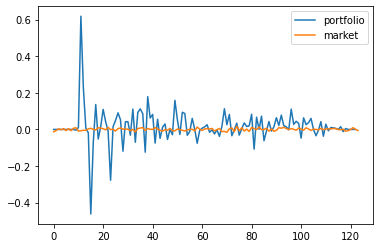

In [51]:
def predict(target_stock):
    '''
    :param target_stock: 预测集文件名
    :return:原始数据集，预测结果
    '''
    sk_model =svm.SVR(kernel='rbf')
    #准备数据
    data_raw,index_data,features_train,labels_train= getStockData(target_stock,20,10000,50000)
    #训练模型
    sk_model = trainModel(features_train,labels_train)
    #验证测试集
    data_raw,index_test,features_test,labels_test = getStockData(target_stock,20,50000,60000)
    predict_data = predictData(sk_model,features_test,labels_test,index_test)
    # yield_rate：收益率计算
    predict_y_r = (predict_data['next_predict'] - predict_data['price']) / predict_data['price']
    predict_data['predict_yield_rate'] = predict_y_r
    y_r = (predict_data['price'] - predict_data['price'].shift(-1)) / predict_data['price'].shift(-1)
    predict_data['yield_rate'] = y_r
    return data_raw,predict_data

# target_stock
s1 = 'stock1.csv'
s2 = 'stock2.csv'
s12 = 'stock12.csv'
s28 = 'stock28.csv'

'''
    :param xxx_raw:原始数据df
    :param xxx_pred:模型生成的df
'''
s1_raw,s1_pred = predict(s1)
s2_raw,s2_pred = predict(s2)
s12_raw,s12_pred = predict(s12)
s28_raw,s28_pred = predict(s28)

start_date = int(s1_pred['date'].iloc[0])   # 50104
list_r1 = [0,0,0,0,0,0,0,0,0]
list_r2 = [0,0,0,0,0,0,0,0,0]
list_r12 = [0,0,0,0,0,0,0,0,0]
list_r28 = [0,0,0,0,0,0,0,0,0]
list_vol = [0,0,0,0,0,0,0,0,0]

for i in range(110):
    start_index = i
    stride = 10     # 设置滑窗 (start_index+stride)值为要预测的date,从50104为第一天开始算

    # 构造协方差矩阵
    PL1 = s1_pred['yield_rate'] # 选择哪一列的数据算协方差
    PL2 = s2_pred['yield_rate']
    PL12 = s12_pred['yield_rate']
    PL28 = s28_pred['yield_rate']
    PL1s = PL1.iloc[start_index:start_index+stride] # 取当日前stride日数据
    PL2s = PL2.iloc[start_index:start_index+stride]
    PL12s = PL12.iloc[start_index:start_index+stride]
    PL28s = PL28.iloc[start_index:start_index+stride]
    PL_df = pd.DataFrame(list(zip(PL1s, PL2s, PL12s, PL28s)))
    PL_df.columns = ['s1', 's2', 's12', 's28']  # 重命名行列名称
    PL_df.index = PL_df.index + start_date
    # 得到协方差矩阵
    PL_cov = PL_df.cov()
    #print(PL_cov)

    # 收益率期望
    m1 = s1_pred['predict_yield_rate'][start_index+stride]  # 取当日前stride日数据
    m2 = s2_pred['predict_yield_rate'][start_index+stride]
    m12 = s12_pred['predict_yield_rate'][start_index+stride]
    m28 = s28_pred['predict_yield_rate'][start_index+stride]
    means = np.array([m1, m2, m12, m28])

    # 单位向量, shape: (1x4)
    L2 = list(np.ones(len(means)))

    # 收益率期望, shape: (1x4)
    L3 = list(means)

    # 矩阵第一行
    L1 = np.append(np.append(PL_cov.swapaxes(0, 1), [np.ones(len(means))], 0), [means], 0).swapaxes(0, 1)

    # 等式左边矩阵
    L2.extend([0, 0])
    L3.extend([0, 0])
    L4 = np.array([L2, L3])
    L = np.append(L1, L4, 0)

    # goal_return
    # 不行xxxxx
    # vw_row = s1_raw.loc[s1_raw["Date"] == start_index+stride-1+start_date]
    # vw = float(vw_row['vwdret'])

    # 相对位置：50104
    vw_filter = s1_raw.loc[s1_raw["Date"]>start_date-1]
    vw_data = vw_filter['vwdret']
    vw_data.index = range(len(vw_data)) # 重新设索引
    vw = vw_data[start_index+stride-1]+0.1
    right = np.array([0,0,0,0,1,vw])   # 等式右边

    # 解方程
    # results = linalg.solve(L, np.append(np.zeros(len(means)), [1, goal_return], 0))
    results = linalg.solve(L, right)
    r = results[:-2]    # 结果
    list_r1.append(r[0])
    list_r2.append(r[1])
    list_r12.append(r[2])
    list_r28.append(r[3])
    portfolio_weights = np.array(r)
    portfolio_volatility = np.sqrt(np.dot(portfolio_weights.T, np.dot(PL_cov, portfolio_weights)))
    list_vol.append(portfolio_volatility)
    # print(i,r)
    #portfolio = pd.DataFrame({'date': i+stride,'stock1': r[0],'stock2':r[1],'stock12':r[2],'stock28':r[3]})
    #print(portfolio)

for i in range(5):
    list_r1.append(0)
    list_r2.append(0)
    list_r12.append(0)
    list_r28.append(0)
    list_vol.append(0)

StockReturns = pd.DataFrame()
# 给dataframe增加列，其中列值要是list类型
# df_name['取个列名'] = 列值
StockReturns['y_r_1'] = list(s1_pred['yield_rate'])
StockReturns['y_r_2'] = list(s2_pred['yield_rate'])
StockReturns['y_r_12'] = list(s12_pred['yield_rate'])
StockReturns['y_r_28'] = list(s28_pred['yield_rate'])
StockReturns['r_1'] = list_r1
StockReturns['r_2'] = list_r2
StockReturns['r_12'] = list_r12
StockReturns['r_28'] = list_r28
stock_return = StockReturns.copy()
stock_return['portfolio'] = stock_return['y_r_1']*stock_return['r_1']+stock_return['y_r_2']*stock_return['r_2']\
                         +stock_return['y_r_12']*stock_return['r_12']+stock_return['y_r_28']*stock_return['r_28']
stock_return['market']= vw_data
stock_return['risk']= list_vol
stock_return.to_csv(r'D:\课件\大三暑期\投资学\1论文\投资组合.csv')
print("投资组合平均收益率：",stock_return['portfolio'].mean(),\
      "市场组合平均收益率：",stock_return['market'].mean(),\
      "投资组合平均标准差：",stock_return['risk'].mean())

# 绘制组合收益随时间变化的图
plt.plot(stock_return['portfolio'],label='portfolio')
plt.plot(stock_return['market'],label='market')
plt.legend(loc='best')
plt.show()

122    4.472373
123         NaN
Name: strategy, dtype: float64


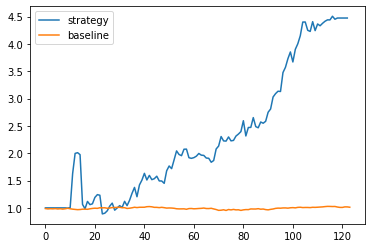

In [49]:
stock_return['strategy'] = (stock_return['portfolio']+ 1).cumprod()
stock_return['baseline'] = (stock_return['market'] + 1).cumprod()
print(stock_return['strategy'][-2:])
# 绘制图形
plt.plot(stock_return['strategy'],label='strategy')
plt.plot(stock_return['baseline'],label='baseline')
plt.legend(loc='best')
plt.show()